# Hospital Analytics and Reporting

In [1]:
import psycopg

conn = psycopg.connect(
    host="pinniped.postgres.database.azure.com", dbname="username",
    user="username", password='password'
)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Hospital Records Loaded in a Specified Week and Comparison with Previous Weeks

In [14]:
selected_week = input("Select a Week (2022-09-23, 2022-09-30, 2022-10-07, 2022-10-14, 2022-10-21): ")

cursor = conn.cursor()

# Execute a query to count records for a selected week
cursor.execute(
    "SELECT COUNT(*) FROM hospitalBedInformation WHERE collection_week = %s", 
    (selected_week,)
)
records_at_week = cursor.fetchone()[0]

# Execute a query to count records for the previous weeks
cursor.execute(
    "SELECT collection_week, COUNT(*) FROM hospitalBedInformation WHERE collection_week < %s GROUP BY collection_week",
    (selected_week,)
)
records_previous_weeks = cursor.fetchall()

# Display the summary
print(f"Hospital records loaded in the specified week: {records_at_week}")
print("\nHospital records loaded in the previous week(s):")

if not records_previous_weeks: 
    print("There are no records for previous weeks.")
for week, count in records_previous_weeks:
    print(f"{week}: {count}")

Hospital records loaded in the specified week: 4996

Hospital records loaded in the previous week(s):
2022-09-30: 4997
2022-09-23: 4995


## Summarizing the Number of Adult and Pediatric Beds Available That Week, the Number Used, and the Number Used by Patients with COVID, Compared to the 4 Most Recent Weeks

In [15]:
selected_week = input("Select a Week (2022-09-23, 2022-09-30, 2022-10-07, 2022-10-14, 2022-10-21): ")

cursor = conn.cursor()

# Execute a query to get statistics for the specified week
cursor.execute(
    "SELECT ROUND(sum(all_adult_hospital_beds_7_day_avg)::numeric, 2), \
            ROUND(sum(all_pediatric_inpatient_beds_7_day_avg)::numeric, 2), \
            ROUND(sum(all_adult_hospital_inpatient_bed_occupied_7_day_coverage)::numeric, 2), \
            ROUND(sum(all_pediatric_inpatient_bed_occupied_7_day_avg)::numeric, 2), \
            ROUND(sum(inpatient_beds_used_covid_7_day_avg)::numeric, 2) \
            FROM hospitalBedInformation WHERE collection_week = %s",
    (selected_week,)
)
week_stats = cursor.fetchone()

values = {
    'Available Adult Beds': [week_stats[0]], 
    'Available Pediatric Beds': [week_stats[1]], 
    'Used Adult Beds': [week_stats[2]], 
    'Used Pediatric Beds': [week_stats[3]], 
    'Used Beds by Patients with COVID': [week_stats[4]]
}
dataframe = pd.DataFrame(data = values)

if week_stats is None:
    print("No statistics found for the specified week.")
    exit()

# Execute a query to get statistics for the 4 most recent weeks
cursor.execute(
   "SELECT collection_week, \
           ROUND(sum(all_adult_hospital_beds_7_day_avg)::numeric, 2), \
           ROUND(sum(all_pediatric_inpatient_beds_7_day_avg)::numeric, 2), \
           ROUND(sum(all_adult_hospital_inpatient_bed_occupied_7_day_coverage)::numeric, 2), \
           ROUND(sum(all_pediatric_inpatient_bed_occupied_7_day_avg)::numeric, 2), \
           ROUND(sum(inpatient_beds_used_covid_7_day_avg)::numeric, 2) \
           FROM hospitalBedInformation \
           GROUP BY collection_week ORDER BY collection_week DESC LIMIT 4"
)
recent_weeks_stats = cursor.fetchall()

columns = ['Week', 'Available Adult Beds', 'Available Pediatric Beds', 'Used Adult Beds', 'Used Pediatric Beds', 'Used Beds by Patients with COVID']
dataframe2 = pd.DataFrame(recent_weeks_stats, columns=columns)

print(f"\nSummary for {selected_week}:")
display(dataframe)

print(f"\nSummary for the 4 most recent weeks:")
display(dataframe2)


Summary for 2022-10-07:


,Available Adult Beds,Available Pediatric Beds,Used Adult Beds,Used Pediatric Beds,Used Beds by Patients with COVID
0,415465.40,39796.80,34886.00,28285.80,23689.30



Summary for the 4 most recent weeks:


,Week,Available Adult Beds,Available Pediatric Beds,Used Adult Beds,Used Pediatric Beds,Used Beds by Patients with COVID
0,2022-10-21,414880.30,39882.20,34376.00,29706.50,24116.80
1,2022-10-14,412939.00,39711.60,34841.00,28799.00,23695.50
2,2022-10-07,415465.40,39796.80,34886.00,28285.80,23689.30
3,2022-09-30,416279.40,39804.70,34852.00,28042.80,24142.50


## Hospital Quality Ratings and Fraction of Beds in Use

All adult and pediatric inpatient bed occupied, divided by the total adult and pediatric beds available.

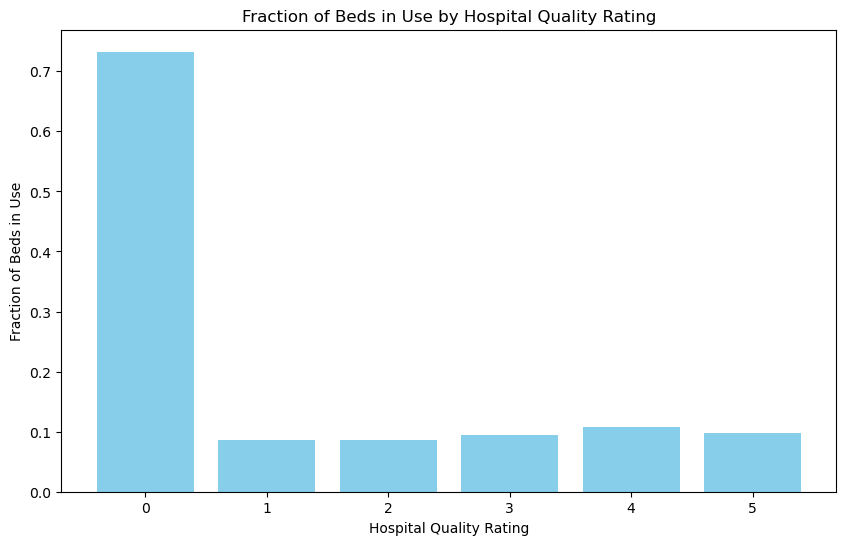

In [16]:
cursor = conn.cursor()

# Execute a query to get statistics for the specified week
cursor.execute(
    "  SELECT hqi.hospital_overall_rating, \
    SUM(hbi.all_adult_hospital_inpatient_bed_occupied_7_day_coverage + hbi.all_pediatric_inpatient_bed_occupied_7_day_avg) / \
    SUM(hbi.all_adult_hospital_beds_7_day_avg + hbi.all_pediatric_inpatient_beds_7_day_avg) as fraction_of_beds_in_use \
    FROM HospitalQualityInformation hqi \
    JOIN HospitalBedInformation hbi ON hqi.facility_id = hbi.hospital_fk \
    GROUP BY hqi.hospital_overall_rating" 
)

columns = [desc[0] for desc in cursor.description]
df = pd.DataFrame(cursor.fetchall(), columns=columns)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df['hospital_overall_rating'], df['fraction_of_beds_in_use'], color = 'skyblue')
plt.title('Fraction of Beds in Use by Hospital Quality Rating')
plt.xlabel('Hospital Quality Rating')
plt.ylabel('Fraction of Beds in Use')
plt.show()

## Total Hospital Beds Used per Week, Inclusive of All Cases and COVID Cases

Text(0, 0.5, 'Number of Beds')

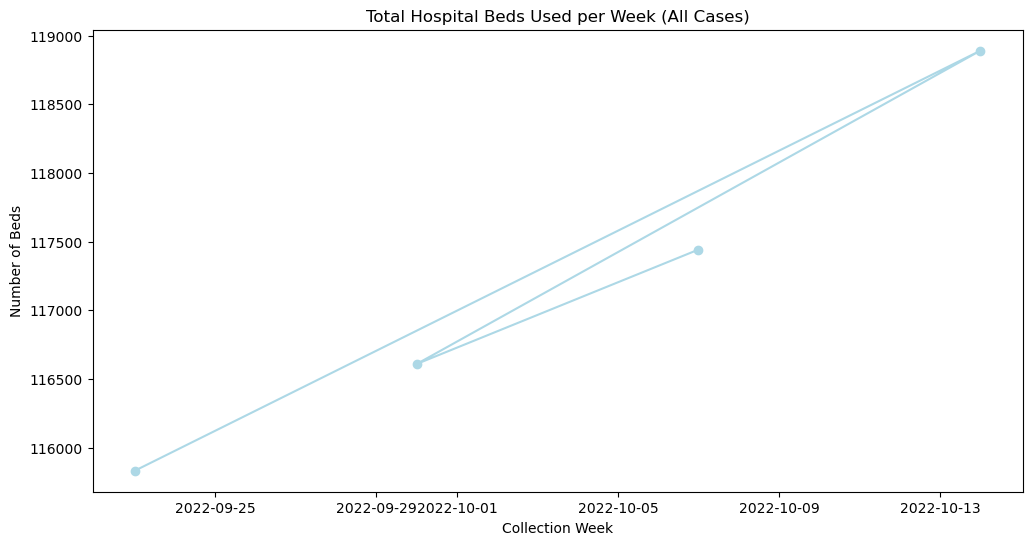

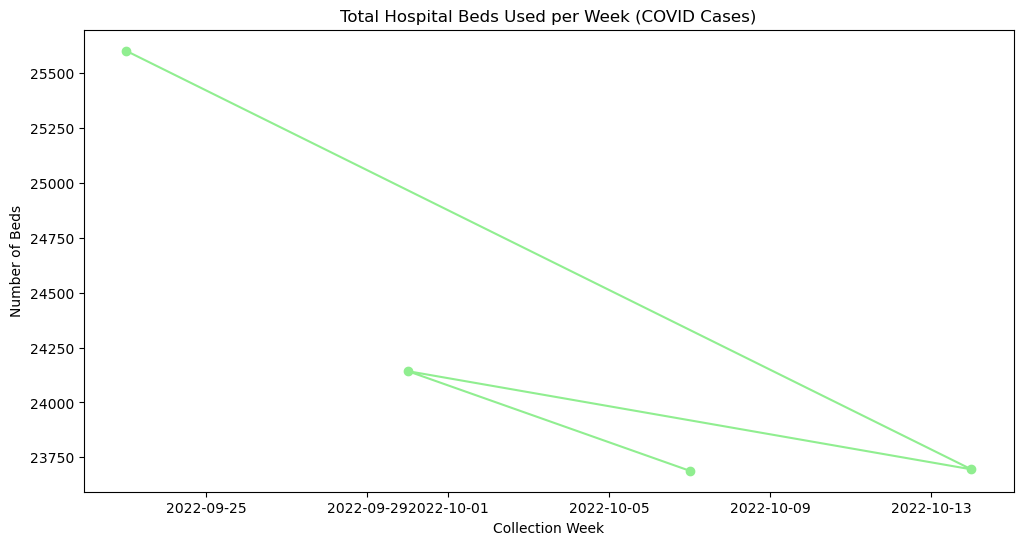

In [17]:
selected_week = input("Select a Week (2022-09-23, 2022-09-30, 2022-10-07, 2022-10-14, 2022-10-21): ")

cursor = conn.cursor()

# Execute a query to count records for a selected week
cursor.execute(
    "SELECT collection_week, \
            SUM(all_adult_hospital_inpatient_bed_occupied_7_day_coverage + all_pediatric_inpatient_bed_occupied_7_day_avg + icu_beds_used_7_day_avg) as all_cases, \
            SUM(inpatient_beds_used_covid_7_day_avg) as covid_cases \
     FROM hospitalBedInformation WHERE collection_week <= %s GROUP BY collection_week", (selected_week, ))

columns = [desc[0] for desc in cursor.description]
df = pd.DataFrame(cursor.fetchall(), columns=columns)

plt.figure(figsize=(12, 6))
plt.plot(df['collection_week'], df['all_cases'], label='Total Beds Used', marker='o', color = 'lightblue')
plt.title('Total Hospital Beds Used per Week (All Cases)')
plt.xlabel('Collection Week')
plt.ylabel('Number of Beds')

plt.figure(figsize=(12, 6))
plt.plot(df['collection_week'], df['covid_cases'], label='COVID Beds Used', marker='o', color = 'lightgreen')
plt.title('Total Hospital Beds Used per Week (COVID Cases)')
plt.xlabel('Collection Week')
plt.ylabel('Number of Beds')

## A Comparison of Emergency Services Availability in the Top 20 States

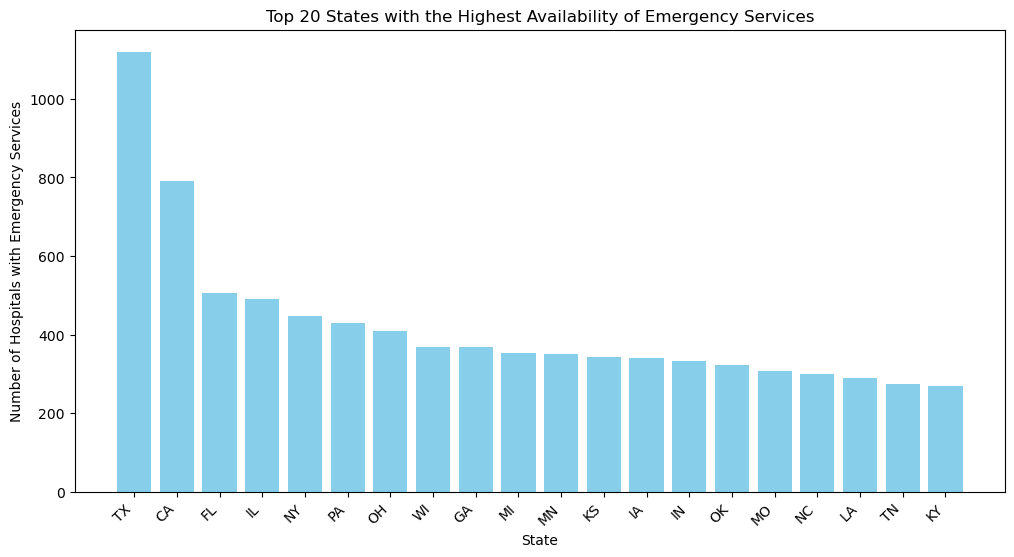

In [18]:
# Create a cursor
cursor = conn.cursor()

# Execute a query to get the availability of emergency services by state
cursor.execute(
    """
    SELECT hl.state, COUNT(*) AS count
    FROM HospitalQualityInformation hq
    JOIN Hospitals h ON hq.facility_id = h.hospital_pk
    JOIN HospitalLocations hl ON h.hospital_pk = hl.hospital_fk
    WHERE hq.emergency_services = TRUE
    GROUP BY hl.state
    """
)

# Fetch the results and convert to a Pandas DataFrame
columns = [desc[0] for desc in cursor.description]
emergency_services_df = pd.DataFrame(cursor.fetchall(), columns = columns)

# Select the top 20 states and sort the DataFrame
top_20_states_df = emergency_services_df.nlargest(20, 'count')

# Plot the availability of emergency services by state (sorted from most to least)
plt.figure(figsize = (12, 6))
plt.bar(top_20_states_df["state"], top_20_states_df["count"], color = 'skyblue')
plt.title("Top 20 States with the Highest Availability of Emergency Services")
plt.xlabel("State")
plt.ylabel("Number of Hospitals with Emergency Services")
plt.xticks(rotation = 45, ha='right')
plt.show()

## Bed Usage Based on Hospital Ownership Type

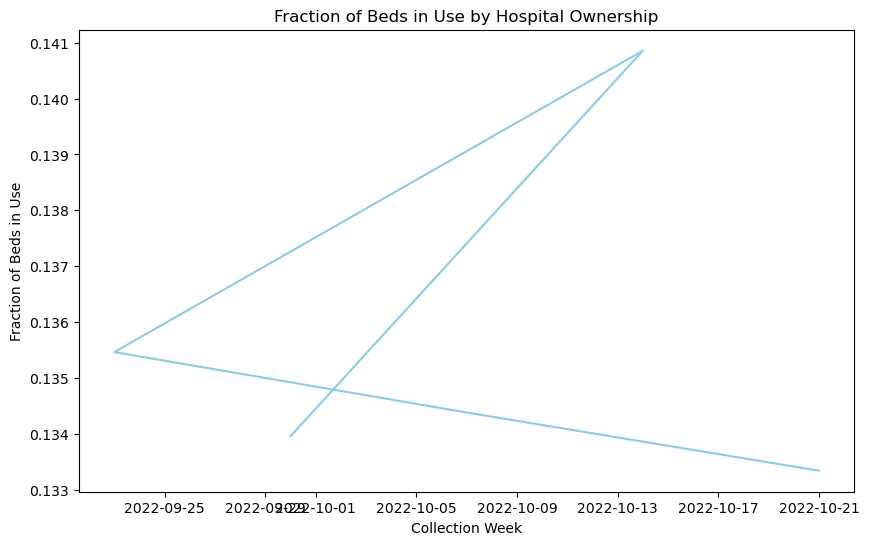

In [13]:
#selected_week = input("Select a Week (2022-09-23, 2022-09-30, 2022-10-07, 2022-10-14, 2022-10-21): ")
selected_owner = input("Select a Hospital Ownership (Government - Federal, Government - Hospital District or Authority, Government - Local, Government - State, Non-Profit - Church Related, Non-Profit - Other, Proprietary, Tribal): ")

# Execute query to get Hospital Ownership Information
cursor.execute(
    "SELECT hq.hospital_ownership, hbi.collection_week, SUM(hbi.all_adult_hospital_inpatient_bed_occupied_7_day_coverage + hbi.all_pediatric_inpatient_bed_occupied_7_day_avg) / SUM(hbi.all_adult_hospital_beds_7_day_avg + hbi.all_pediatric_inpatient_beds_7_day_avg) as fraction_of_beds_in_use \
    FROM HospitalQualityInformation hq \
    JOIN HospitalBedInformation hbi ON hq.facility_id = hbi.hospital_fk \
    WHERE hq.hospital_ownership = %s \
    GROUP BY hq.hospital_ownership, hbi.collection_week", (selected_owner, )
)
     
columns = [desc[0] for desc in cursor.description]
df = pd.DataFrame(cursor.fetchall(), columns=columns)




# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df['collection_week'], df['fraction_of_beds_in_use'], color = 'skyblue')
plt.title('Fraction of Beds in Use by Hospital Ownership')
plt.xlabel('Collection Week')
plt.ylabel('Fraction of Beds in Use')
plt.show()

## Hospitals That Did Not Report Any Data in the Past Week